In [1]:
import tensorflow as tf
import json
import os

from core.data  import load_records
from core.transformer import ASTROMER
from core.scheduler import CustomSchedule
from core.callbacks import get_callbacks
from core.losses import CustomMSE, ASTROMERLoss, CustomBCE
from core.metrics import CustomACC
from core.plot import plot_lc

import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)

plt.style.use('dark_background')

%load_ext autoreload
%autoreload 2

In [2]:
root_data = './experiments/macho_1'
conf_file = os.path.join(root_data, 'conf.json')

with open(conf_file, 'r') as handle:
    conf = json.load(handle)
conf

{'max_obs': 200,
 'data': './data/records/macho',
 'p': './experiments/macho_1',
 'batch_size': 256,
 'epochs': 2000,
 'layers': 2,
 'heads': 4,
 'head_dim': 812,
 'dff': 1024,
 'dropout': 0.25,
 'base': 10000,
 'lr': 0.001}

In [3]:
test_batches = load_records(os.path.join(conf['data'], 'test'), 
                             conf['batch_size'], 
                             input_len=conf['max_obs'])

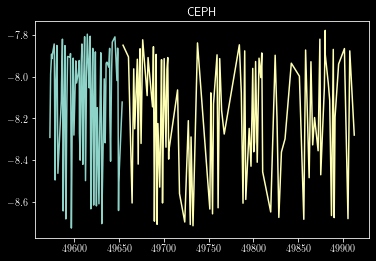

In [4]:
fig, axes = plt.subplots(1,1)
for batch in test_batches:
    plot_lc(batch, axes, conf['data'], n=0)
    break

In [5]:
learning_rate = 1e-3#CustomSchedule(opt.head_dim)
optimizer = tf.keras.optimizers.Adam(learning_rate, 
                                     beta_1=0.9, 
                                     beta_2=0.98, 
                                     epsilon=1e-9)
# Model Instance
transformer = ASTROMER(num_layers=conf['layers'],
                    d_model=conf['head_dim'],
                    num_heads=conf['heads'],
                    dff=conf['dff'],
                    rate=conf['dropout'])

# Model Instance
transformer = ASTROMER(num_layers=conf['layers'],
                       d_model=conf['head_dim'], 
                       num_heads=conf['heads'],
                       dff=conf['dff'],
                       rate=conf['dropout'],
                       base=conf['base']) 

# Compile
transformer.compile(optimizer=optimizer, 
                    loss=ASTROMERLoss(),
                    metrics=[CustomMSE(), CustomBCE(), CustomACC()])
# Create graph
transformer.model(conf['batch_size']).summary()

# Initialize graph
transformer.evaluate(test_batches.take(1))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Serie1 (InputLayer)             [(256, 50, 3)]       0                                            
__________________________________________________________________________________________________
Serie2 (InputLayer)             [(256, 50, 3)]       0                                            
__________________________________________________________________________________________________
steps_1 (InputLayer)            [(256,)]             0                                            
__________________________________________________________________________________________________
steps_2 (InputLayer)            [(256,)]             0                                            
______________________________________________________________________________________________

[11.348589897155762,
 10.582825660705566,
 0.7657632827758789,
 0.4166666567325592]

In [6]:
expdir = '{}/train_model.h5'.format(conf['p'])
transformer.load_weights(expdir)
transformer.evaluate(test_batches)

1/1 [==============================] - 1s 591ms/step - loss: 0.7154 - MSE: 0.0141 - BCE: 0.7013 - Accuracy: 0.4167


[0.7154197096824646,
 0.014077906496822834,
 0.7013418078422546,
 0.4166666567325592]

In [7]:
rec_pred, rec_mask, rec_true, rec_times, cls_pred, cls_true = transformer.predict(test_batches)

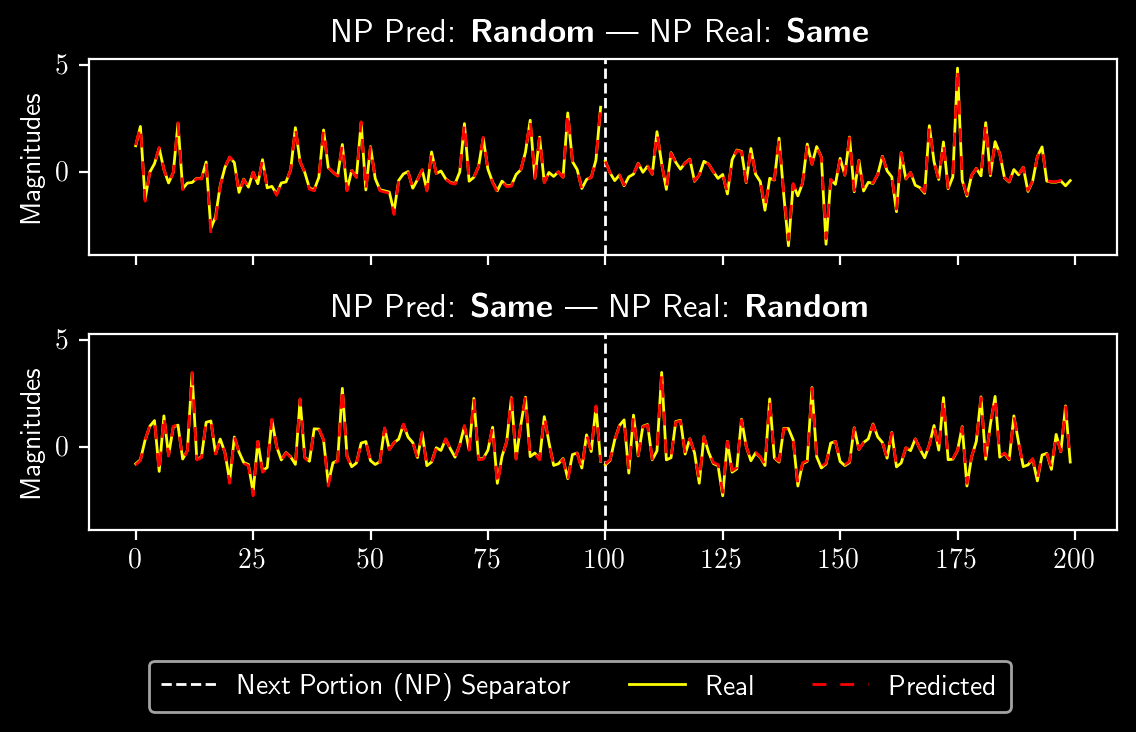

In [11]:
N = 2
fig, axes = plt.subplots(N, 1, dpi=200, sharey=True, sharex=True)

obs = conf['max_obs']//2

for i in range(N):

    times_prev = range(0, obs)
    times_post = range(obs, obs*2)
    
    serie_1_pred = rec_true[i][:obs, 0]
    serie_1_true = rec_pred[i][:obs]

    serie_2_pred = rec_true[i][obs+1:-1, 0]
    serie_2_true = rec_pred[i][obs+1:-1]
    
    
    axes[i].axvline(x=obs, color='white', linewidth=1, linestyle='--', label='Next Portion (NP) Separator')

    axes[i].plot(times_prev, serie_1_pred, marker='',linewidth=1, linestyle='-', color='yellow')
    axes[i].plot(times_prev, serie_1_true, marker='',linewidth=1, linestyle='--', color='red', dashes=(5, 5))

    axes[i].plot(times_post, serie_2_true, marker='',linewidth=1, linestyle='-', color='yellow', label='Real')
    axes[i].plot(times_post, serie_2_pred, marker='',linewidth=1, linestyle='--', color='red', dashes=(5, 5),label='Predicted')
    

    npp_lab_pred = 'Random' if cls_pred[i] == 1 else 'Same'
    npp_lab_true = 'Random' if cls_true[i] == 1 else 'Same'
    axes[i].set_title(r"NP Pred: \textbf{"+npp_lab_pred+"}"
                   +" | "+r"NP Real: \textbf{"+npp_lab_true+"}")

    axes[i].set_ylabel('Magnitudes')
    
axes[i].legend(ncol=3, bbox_to_anchor = (0.91, -0.6))
fig.tight_layout()

# todo

- weigh loss function by magnitude values
- increase masked values
- decrease number of observations in the training set
- build model diagram

In [12]:
attention_vector = transformer.get_attention(test_batches.take(2))

In [13]:
z = tf.concat(attention_vector, 0)
z.shape

TensorShape([12, 203, 812])

In [14]:
z_r = tf.reshape(z, [z.shape[0], z.shape[1],  conf['heads'], z.shape[-1]//conf['heads']])
z_r = tf.transpose(z_r, [2,0,1,3])

In [15]:
z_m = tf.reduce_mean(z_r, 0)

In [19]:
single_att = z_m[0][1:obs, 1:obs]

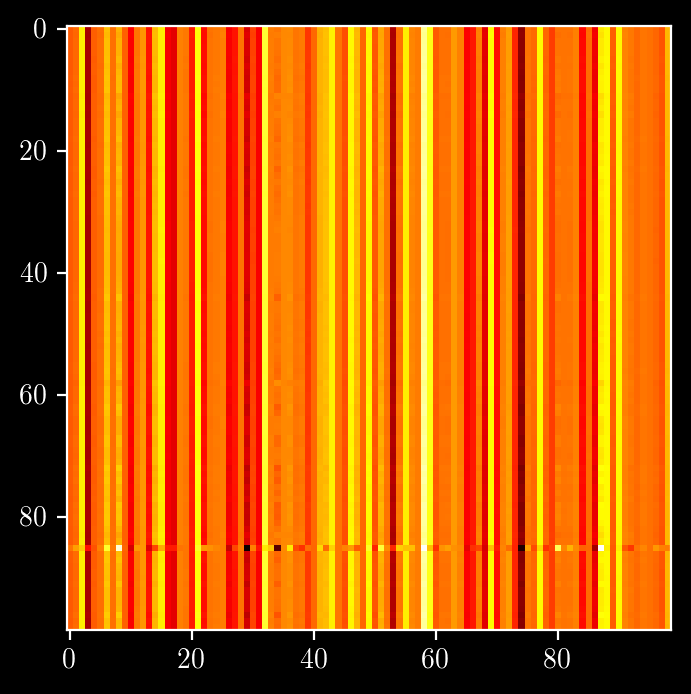

In [21]:
plt.figure(dpi=200)
plt.imshow(single_att, cmap='hot', interpolation='nearest')
plt.show()